# Load data

In [1]:
import pandas as pd

In [3]:
data = pd.read_csv('org_detected_2022.csv', index_col = 0)
data.head()

doc_id                                                txt  \
0  2022010  MA 10 und Katholischer Familienverband der Erz...   
1  2022010                                        KURZFASSUNG   
2  2022010  Der Stadtrechnungshof Wien unterzog die Gebaru...   
3  2022010  Der Stadtrechnungshof Wien würdigte das Angebo...   
4  2022010  Verbesserungspotenziale zeigten sich ferner be...   

                                            entities  
0  ['MA 10', 'Katholischer Familienverband der Er...  
1                                                 []  
2  ['Stadtrechnungshof Wien', 'Katholischen Famil...  
3  ['Stadtrechnungshof Wien', 'Stadtrechnungshof ...  
4  ['Katholischen Familienverband der Erzdiözese ...

# Cleanse entity

In [4]:
import re

def str_to_list(df, to_list_col = 'entities'):
    d = df.copy()
    col_name = to_list_col+'_list'
    d[col_name] = ''
    for i in range(len(d)):
        temp = re.split(',', d[to_list_col][i])
        temp_remove = [re.sub('\'','',x) for x in temp]
        temp_remove = [re.sub('\[','',x) for x in temp_remove]
        temp_remove = [re.sub('\]','',x) for x in temp_remove]
        temp_remove = [re.sub('\.','',x) for x in temp_remove] # remove punct
        temp_remove = [re.sub('\-','',x) for x in temp_remove] # remove hyphen
        
        # unify as 'MA'
        temp_remove = [re.sub('Magistratsabteilungen','MA',x) for x in temp_remove]
        temp_remove = [re.sub('Magistratsabteilung','MA',x) for x in temp_remove]
        temp_remove = [re.sub('MA 0','MA',x) for x in temp_remove]
        
        # remove redundent space at the start of the entities
        temp_remove = [x.lstrip() for x in temp_remove]
                
        d.at[i,col_name] = temp_remove
        
    d = d.drop([to_list_col], axis = 1)
    return d

d = str_to_list(data)
d.head()

doc_id                                                txt  \
0  2022010  MA 10 und Katholischer Familienverband der Erz...   
1  2022010                                        KURZFASSUNG   
2  2022010  Der Stadtrechnungshof Wien unterzog die Gebaru...   
3  2022010  Der Stadtrechnungshof Wien würdigte das Angebo...   
4  2022010  Verbesserungspotenziale zeigten sich ferner be...   

                                       entities_list  
0  [MA 10, Katholischer Familienverband der Erzdi...  
1                                                 []  
2  [Stadtrechnungshof Wien, Katholischen Familien...  
3  [Stadtrechnungshof Wien, Stadtrechnungshof Wie...  
4  [Katholischen Familienverband der Erzdiözese W...

In [5]:
# get all entities
ent_all= [item for sublist in d['entities_list']
          for item in sublist if len(item)>1]

# #remove redundent space
# for i in range(len(ent_all)):
#     org = ent_all[i]
#     if org.startswith(" "):
#         ent_all[i] = org[1:]

#get unique list of orgs
ent_unique = list(set(ent_all))
for i in ent_unique:
    print(i, ent_all.count(i))

Stadt WienLogos 1
Stadtrechnungshof WIEN 1
Verkehrsverbund Großraum Nürnberg GmbH 7
Wiener Krankenanstaltenplan 3
Zentralkrankenanstalt Allgemeines Krankenhaus 1
Kommunal Kredit Public Consulting 1
Kuratoriums Wiener PensionistenWohnhäuser 1
Stadt WienVertretern 1
MA 13 205
Theater am Petersplatz GmbH 2
Stadtverwaltung Frankfurt 1
Österreichischen Familienverband der Erzdiözese 1
MA 56 97
AFRAC 1
MA 31 14
Verkehrsverbundes 2
Wissenschaft und Forschung 2
Unternehmung Wien Kanal und EMobilität 421 1
Verein ORIENT 9
Petersplatz GmbH 2
Unternehmung Wien Kanal 2006 1
Wiener PensionistenWohnhäusern 1
MA 34 211
Wiener HafenGruppe 4
Verschmelzung der 1
Liegenschaften der Wiener Messe Besitz GmbH 1
MA 33 65
Österreichischen Städtebundes 5
Wiener Stadtrechnungshofes 1
AWZ Soziales Wien 1
Seite der Vienna Film Commission GmbH 1
Krankenanstaltenverbundes 10
Krankenfürsorgeanstalt der Bediensteten 4
Wiener Linien GmbH & Co KG 3
Landesfachverband Rugby Wien 59
MA 49 115
Klimaschutz 3
MA 36 36
Europä

In [6]:
import nltk
# find the same unique
same_orgs = []
for i in range(len(ent_unique)-1):

    org = ent_unique[i]
    
    if not org.startswith("MA"):
        
        org_set = [org]

        for j in range(i+1,len(ent_unique)):
            compared_org = ent_unique[j]
            edit_dist = nltk.edit_distance(org,compared_org)
            edit_percent = edit_dist / max(len(org),len(compared_org))


            if edit_percent < 0.25:
                org_set.append(compared_org)


    if len(org_set) > 1:
        if same_orgs.count(org_set) == 0:
            same_orgs.append(org_set)
len(same_orgs)

98

# Clean same_orgs

In [7]:
# check if one org is in more than 2 same_orgs group
check_same_orgs = [item for sublist in same_orgs for item in sublist]
dup_same_orgs = list(set([x for x in check_same_orgs if check_same_orgs.count(x) > 1]))
dup_same_orgs


# about orgs in dup_same_orgs: merge groups containing dup orgs
merge = []
drop = []
for i in dup_same_orgs:
    merge_candidate = []
    
    for j in same_orgs:
        
        if i in j:
            merge_candidate.append(j)
            drop.append(j)
            
    new_group = list(set([item for sublist in merge_candidate for item in sublist]))        
    if new_group not in merge:
        merge.append(new_group)
        
merge_again = []
for i in merge:
    merge_candidate = [i]
    for element in i:
        for j in merge:
            if i != j:
                if element in j:
                    merge_candidate.append(j)
                    
    new_group = list(set([item for sublist in merge_candidate for item in sublist]))
    if new_group not in merge_again:
        merge_again.append(new_group)                   

In [8]:
org_list_new = same_orgs.copy()
for i in drop:
    if i in org_list_new:
        org_list_new.remove(i)
for j in merge_again:
    org_list_new.append(j)
len(org_list_new)

63

# add cleansed orgs to df

In [9]:
ent_for_cleansing = d['entities_list'].copy()

In [10]:
for i in range(len(d['entities_list'])):

    for j in range(len(d['entities_list'][i])):

        
        for orgs in org_list_new:

            if d['entities_list'][i][j] in orgs:
                print(d['entities_list'][i][j])
                d['entities_list'][i][j] = max(orgs, key = len)
                print(d['entities_list'][i][j], '\n\n')
                

Katholischer Familienverband der Erzdiözese Wien
Katholischen Familienverbandes der Erzdiözese Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Katholischen Familienverbandes der Erzdiözese Wien
Katholischen Familienverbandes der Erzdiözese Wien 


Katholische Familienverband der Erzdiözese Wien
Katholischen Familienverbandes der Erzdiözese Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Katholischen Familienverband der Erzdiözese Wien
Katholischen Familienverbandes der Erzdiözese Wien 


Katholischen Familienverband der Erzdiözese Wien
Katholischen Familienverbandes der Erzdiözese Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Katholischer Familienverband der Erzdiözese Wien
Katholischen Familienverbandes der Erzdiözese Wien 


Katholischer Familienverband Wien
Katholischen Familienverbandes Wien 


Katholischer Familienverband der Erzdiözese Wien
Katholischen Familienverbandes der Erzdiözese Wien 


S

Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnu

Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Community TV GmbH 


Community TVGmbH
Commu

Landesfachverband Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Vereines Landesfachverbandes Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Landesfachverband Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Vereines Landesfachverbandes Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Landesfachverbandes Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Vereines Landesfachverbandes Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Österreichischen BSO
Österreichischen BSO 


Landesfachverband Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Vereines Landesfachverbandes Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Landesfachverband Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Vereines Landesfachverbandes Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Landesfachverband Rugby Wien
Vereines Landesfachverbandes Rugby Wien 


Vere

Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Bioforschung Austria
Bio Forschung Austria 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Vereines Bioforschung Austria
Institutes Bioforschung Austria 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Bioforschung Austria
Bio Forschung Austria 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Vereines Bioforschung Austria
Institutes Bioforschung Austria 


Vereines Bioforschung Austria
Institutes Bioforschung Austria 


Stadt Wien
stadt wien 


Bio Forschung Austria
Bio Forschung Austria 


Stadt Wien
stadt wien 


Bio Forschung Austria
Bio Forschung Austria 


Stadt Wien
stadt wien 


Bio Forschung Austria
Bio Forschung Austria 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofausschusses
Stadtrechnungshofausschusses 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbund
Gesundheitsverbundes 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Gesundheitsverbund
Gesundheitsverbundes 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadtrechnungshof Wien
Stadtr


Wiener Krankenanstaltenverbundes
Wiener Krankenanstaltenverbundes 


Wiener Krankenanstaltenverbundes
Wiener Krankenanstaltenverbundes 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Gesundheitsverbund
Gesundheitsverbundes 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbund
Gesundheitsverbundes 


Wiener Städtischen Krankenhäuser
Wiener Städtischen Krankenhäusern 


Stadt Wien
stadt wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbund
Gesundheitsverbundes 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbund
Gesundheitsverbundes 


Stadtrechnungshof Wien

Wiener Städtischen Krankenhäusern 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Wiener Städtischen Krankenhäuser
Wiener Städtischen Krankenhäusern 


Gesundheitsverbund
Gesundheitsverbundes 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Wiener Städtischen Krankenhäuser
Wiener Städtischen Krankenhäusern 


Wiener Städtischen Krankenhäuser
Wiener Städtischen Krankenhäusern 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Wiener Städtischen Krankenhäusern
Wiener Städtischen Krankenhäusern 


Wiener Städtischen Krankenhäuser
Wiener Städtischen Krankenhäusern 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Wiener Städtischen Krankenhäuser
Wiener Städtischen Krankenhäusern 


Stadtrechnungshof Wien
St

Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stad

Unternehmung Wien Kanal 2006 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Unternehmung Wien Kanal 2006
Unternehmung Wien Kanal 2006 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Europäischen Parlaments
Europäischen Parlaments 


Stadt Wien
stadt wien 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Unternehmung Wie


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtre

Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Bundesministerium für Gesundheit
Bundesministerium für Klimaschutz 


Bundesministerium für Klimaschutz
Bundesministerium für Klimaschutz 


Bundesministerium für Gesundheit
Bundesministerium für Klimaschutz 


Bundesministerium für Klimaschutz
Bundesministerium für Klimaschutz 


Stadt Wien
stadt wien 


Wiener Krankenanstaltenplan
Wiener Krankenanstaltenverbundes 


Bundesminister für Soziales
Bundesministerium für Soziales 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Gesundheitsverbund
Gesundheitsverbundes 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbundes
Gesundheitsverbundes 


Wiener Gesundhe

Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


insert Tanz und Performance GmbH
insert Tanz und Performance GmbH 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrec

Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs
Gesellschaft Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs 


Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs GmbH
Gesellschaft Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs 


Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs GmbH
Gesellschaft Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs 


Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs GmbH
Gesellschaft Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs 


Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs GmbH
Gesellschaft Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs 


Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs GmbH
Gesellschaft Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs 


Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs GmbH
Gesellschaft Wiener Donauraum Länden und Ufer Betriebs und Entwicklungs 


Wiener Donauraum Länden und Ufer

KraftwerkGulling GmbH & Co KG
Kraftwerk Gulling GmbH & Co KG 


KraftwerkGulling GmbH & Co KG
Kraftwerk Gulling GmbH & Co KG 


KraftwerkGulling GmbH & Co KG
Kraftwerk Gulling GmbH & Co KG 


KraftwerkGulling GmbH & Co KG
Kraftwerk Gulling GmbH & Co KG 


KraftwerkGulling GmbH & Co KG
Kraftwerk Gulling GmbH & Co KG 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


KraftwerkGulling GmbH & Co KG
Kraftwerk Gulling GmbH & Co KG 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


KraftwerkGulling GmbH & Co KG
Kraftwerk Gulling GmbH & Co KG 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


KraftwerkGulling GmbH & Co KG
Kraftwerk Gulling GmbH & Co KG 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


KraftwerkGulling GmbH & Co KG
Kraftwerk Gulling GmbH & Co KG 


KraftwerkGul

WIENER STADTWERKE GmbH
WIENER STADTWERKEKonzerns 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


WIENER STADTWERKEKonzern
WIENER STADTWERKEKonzerns 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


WIENER STADTWERKE GmbH
WIENER STADTWERKEKonzerns 


WIENER STADTWERKEKonzern
WIENER STADTWERKEKonzerns 


WIENER STADTWERKE GmbH
WIENER STADTWERKEKonzerns 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


WIENER STADTWERKE GmbH
WIENER STADTWERKEKonzerns 


WIENER STADTWERKEKonzern
WIENER STADTWERKEKonzerns 


WIENER STADTWERKEKonzerns
WIENER STADTWERKEKonzerns 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


WIENER STADTWERKEKonzern
WIENER STADTWERKEKonzerns 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


WIENER STADTWERKE GmbH
WIENER STADTWERKEKonzerns 


Wien HoldingKonzern
Wien HoldingKonzerns 


WIENER STADTWERKEKonzern
WIENER STADTWERKEKonzerns 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


WIENER STADTWERKE GmbH
WIENER STADTWERKEKonzerns 


WIENER STADTW

Stadtrechnungshofes Wien 


Wiener Messe Besitz GmbH
Wiener Messe Besitz GmbH 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Wiener Messe Besitz GmbH
Wiener Messe Besitz GmbH 


Wiener Messe Besitz GmbH
Wiener Messe Besitz GmbH 


Wiener Messe Besitz GmbH
Wiener Messe Besitz GmbH 


Stadt Wien
stadt wien 


Wiener Messe Besitz GmbH
Wiener Messe Besitz GmbH 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Wiener Messe Besitz GmbH
Wiener Messe Besitz GmbH 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Wiener Messe Besitz GmbH
Wiener Messe Besitz GmbH 


Wiener Messe Besitz GmbH
Wiener Messe Besitz GmbH 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Wiener Messe Besitz GmbH
Wiener Messe Besitz GmbH 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Wiener Messe Besitz GmbH
Wie

Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbundes
Gesundheitsverbundes 


Gesundheitsverbundes
Gesundheitsverbundes 


Wiener Gesundheitsfonds
Wiener Gesundheitsverbundes 


Gesundheitsverbund
Gesundheitsverbundes 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Gesundheitsverbundes
Gesundheitsverbundes 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien

Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Mitteilung der WIENER LINIEN GmbH & Co KG
Mitteilung der WIENER LINIEN GmbH & Co KG 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Netz der WIENER LINIEN GmbH & Co KG
Mitteilung der WIENER LINIEN GmbH & Co KG 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Verkehrsverbund Großraum Nürnberg
Verkehrsverbund Großraum Nürnberg GmbH 


Verkehrsverbund Großraum Nürnberg GmbH
Verkehrsverbund Großraum Nürnberg GmbH 


Verkehrsverbund Großraum Nürnberg
Verkehrsverbund Großraum 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Wiener Volksschulen GmbH
Die

Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


S

Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Unternehmung Wien Kanal
Unternehmung Wien Kanal 2006 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnung

Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadtrechnungshof Wien
Stadtrech


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofausschusses
Stadtrechnungshofausschusses 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshof Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 


Stadt Wien
stadt wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadtrechnungshofes Wien
Stadtrechnungshofes Wien 


Stadt Wien
stadt wien 




In [12]:
d['entities_cleansed'] = ent_for_cleansing

In [13]:
d.head()

doc_id                                                txt  \
0  2022010  MA 10 und Katholischer Familienverband der Erz...   
1  2022010                                        KURZFASSUNG   
2  2022010  Der Stadtrechnungshof Wien unterzog die Gebaru...   
3  2022010  Der Stadtrechnungshof Wien würdigte das Angebo...   
4  2022010  Verbesserungspotenziale zeigten sich ferner be...   

                                       entities_list  \
0  [MA 10, Katholischen Familienverbandes der Erz...   
1                                                 []   
2  [Stadtrechnungshofes Wien, Katholischen Famili...   
3  [Stadtrechnungshofes Wien, Stadtrechnungshofes...   
4  [Katholischen Familienverbandes der Erzdiözese...   

                                   entities_cleansed  
0  [MA 10, Katholischen Familienverbandes der Erz...  
1                                                 []  
2  [Stadtrechnungshofes Wien, Katholischen Famili...  
3  [Stadtrechnungshofes Wien, Stadtrechnungshofes...  
4  [Katholischen Familienverbandes der Erzdiözese...

In [81]:
from itertools import combinations

In [89]:
temp = []
for i in d.entities_cleansed[:10]:
    a = list(combinations(list(set(i)), 2))
    for j in a:
        temp.append(j)
unique = list(set(temp))
for i in unique:
    print(i[0], temp.count(i))

Katholischen Familienverbandes der Erzdiözese Wien 4
Stadtrechnungshofes Wien 1
MA 10 1
Stadtrechnungshofes Wien 3
Katholischen Familienverbandes der Erzdiözese Wien 3
Katholischen Familienverbandes der Erzdiözese Wien 2


In [114]:
a= ['','a','b']
a.remove('')
a

['a', 'b']

In [120]:
doc_id_unique = list(set(list(d['doc_id'])))

count = 0
cooccur_freq = pd.DataFrame(columns = ['doc_id', 'org_name1', 'org_name2', 'freq'])

for i in doc_id_unique:
    temp = []
    
    bydoc = d.loc[d["doc_id"] == i]
    bydoc = bydoc.reset_index(drop = True)
    entities_bypara = list(bydoc["entities_cleansed"])
    
    for paraent in entities_bypara:
        if len(paraent) > 1:
            u_paraent = list(set(paraent))
            if '' in u_paraent:
                u_paraent.remove('')
            if 'Stadtrechnungshofes Wien' in u_paraent:
                u_paraent.remove('Stadtrechnungshofes Wien')
            if 'stadt wien' in u_paraent:
                u_paraent.remove('stadt wien')
            u_paraent.sort()
            combi = list(combinations(u_paraent, 2))
            for c in combi:
                temp.append(c)
    unique_combi = list(set(temp))
    for unique_c in unique_combi:
        cooccur_freq.loc[count] = [i, unique_c[0], unique_c[1], temp.count(unique_c)]
        count += 1            
cooccur_freq

doc_id                                        org_name1  \
0     202203100                                            MA 11   
1     202203100                                            MA 11   
2     202203101                                            MA 10   
3     202203101                                            MA 10   
4     202203101                                            MA 10   
...         ...                                              ...   
3448   20220397                                            MA 34   
3449   20220397                                            MA 10   
3450   20220397  Bundesministeriums für Land und Forstwirtschaft   
3451   20220398                                            MA 58   
3452   20220399                                            MA 58   

                                  org_name2  freq  
0              Stadtrechnungshofausschusses     1  
1                                     MA 34     3  
2                                     MA 13     1  
3                                     MA 42     1  
4                                     MA 68     1  
...                                     ...   ...  
3448  WIP Wiener Infrastruktur Projekt GmbH     2  
3449  WIP Wiener Infrastruktur Projekt GmbH     1  
3450            Umwelt und Wasserwirtschaft     1  
3451                                  MA 60     2  
3452                                  MA 60     2  

[3453 rows x 4 columns]

In [121]:
cooccur_freq.to_csv('cooccur_freq_bydoc_noswsw.csv')

# Count Frequency

In [14]:
doc_id_unique = list(set(list(d['doc_id'])))
len(doc_id_unique)

106

In [33]:
ents = list(d['entities_cleansed'])
ent_list_all =  [item for sublist in ents for item in sublist if len(item)>1]
unique_ent_all = list(set(ent_list_all))
count_ent = pd.DataFrame(columns = ['ent', 'freq'])
count = 0
for i in unique_ent_all:
    if ent_list_all.count(i) > 2: # remove not freqent ones
        count_ent.loc[count] = [i,ent_list_all.count(i)]
        count += 1
count_ent    

ent  freq
0       Verkehrsverbund Großraum Nürnberg GmbH    11
1    Kuratoriums Wiener PensionistenWohnhäuser     7
2                                        MA 13   205
3                  Theater am Petersplatz GmbH    19
4                                        MA 56    97
..                                         ...   ...
200                                         24     3
201                       Gesundheit und Sport    17
202      Wohnbeihilfe Wiener Wohnbauförderungs     4
203                                      MA 48   127
204          Wiener Städtischen Krankenhäusern    89

[205 rows x 2 columns]

In [34]:
!pip install wordcloud

     -------------------------------------- 153.1/153.1 kB 1.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import matplotlib.pyplot as plt
import wordcloud

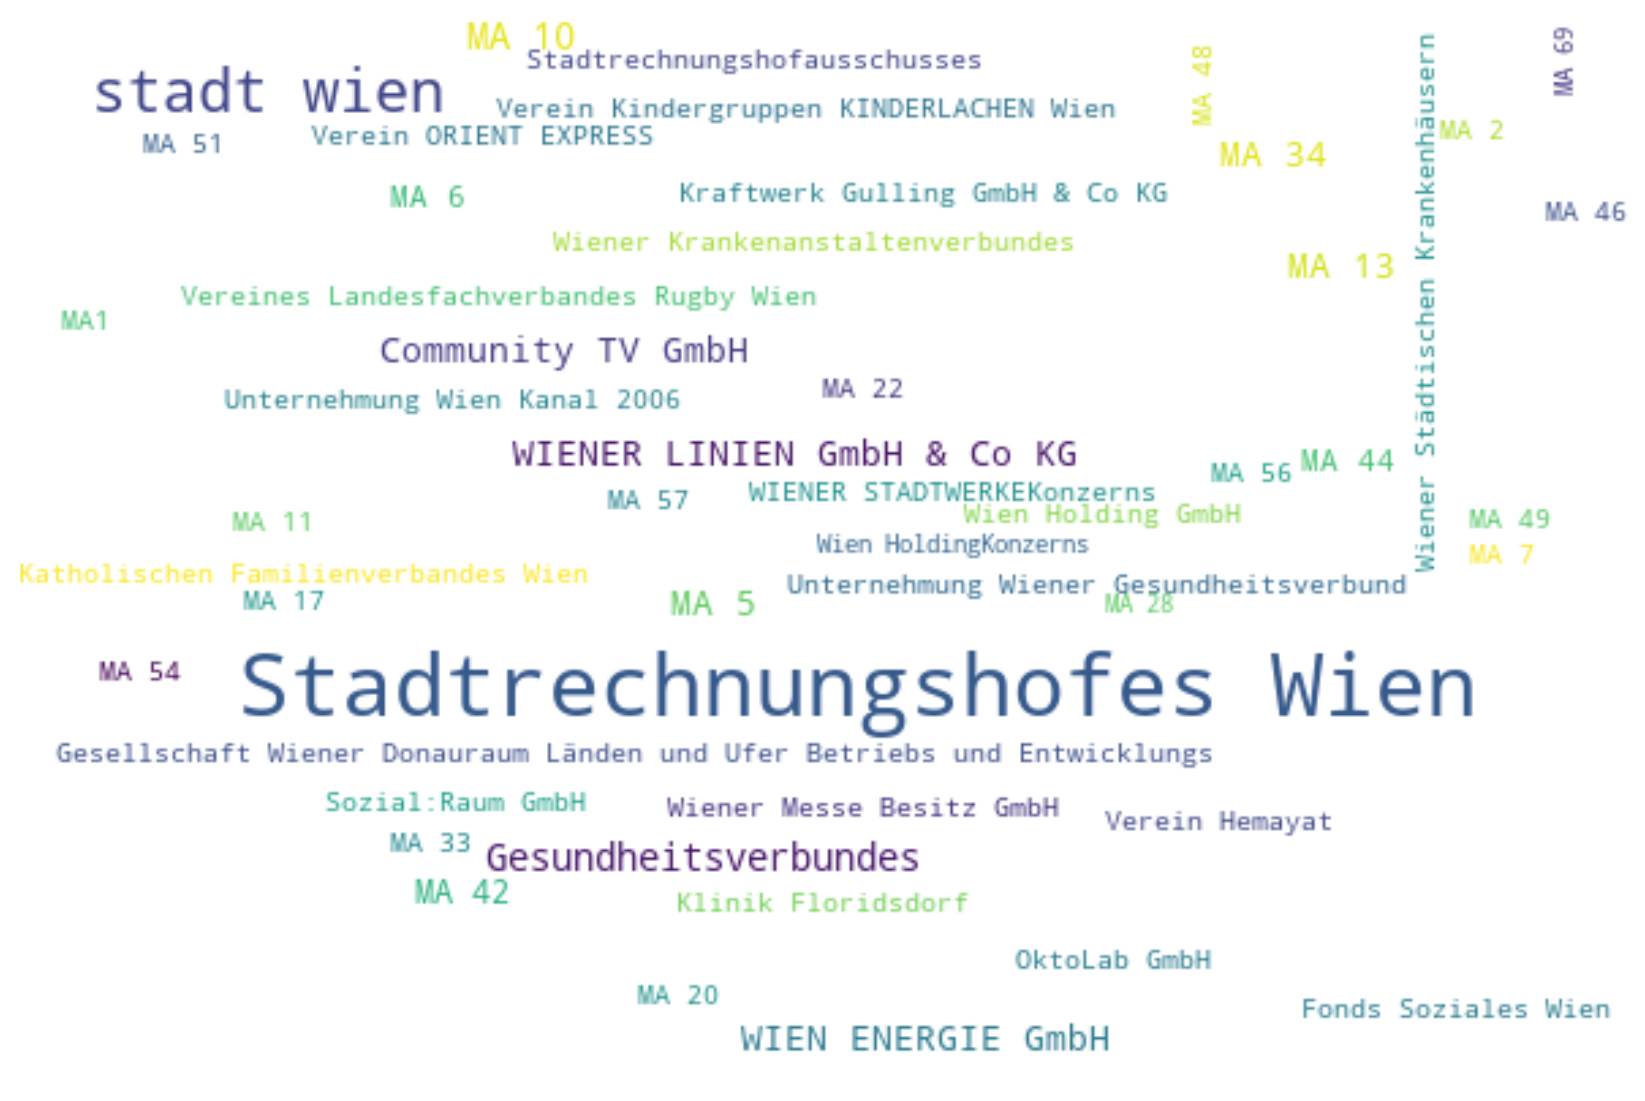

In [59]:
tuples = [tuple(x) for x in count_ents_sort[:50].values]
wc = wordcloud.WordCloud(width =600, height = 400,
                background_color ='white').generate_from_frequencies(dict(tuples))
plt.figure(figsize = (30, 20), facecolor = None)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [60]:
count_ents_sort = count_ent.sort_values(by=['freq'], ascending=False)
count_ents_sort = count_ents_sort.reset_index(drop = True)
count_ents_sort[:10]

ent  freq
0    Stadtrechnungshofes Wien  2682
1                  stadt wien   951
2        Gesundheitsverbundes   296
3                       MA 10   277
4           WIEN ENERGIE GmbH   236
5           Community TV GmbH   225
6                       MA 34   211
7                        MA 5   210
8                       MA 13   205
9  WIENER LINIEN GmbH & Co KG   195

In [63]:
unique_ent = list(count_ents_sort['ent'])

In [70]:
doc_id_unique = list(set(list(d['doc_id'])))
len(doc_id_unique)

count = 0
entity_freq = pd.DataFrame(columns = ['doc_id', 'org_name', 'freq'])
for i in doc_id_unique:
    temp = d.loc[d["doc_id"] == i]
    temp1 = list(temp['entities_cleansed'])
    ent_list =  [item for sublist in temp1 for item in sublist if len(item)>1]
      
    for j in unique_ent:
        if j in ent_list:
            entity_freq.loc[count] = [i,j,ent_list.count(j)]
            count += 1
entity_freq

doc_id                      org_name  freq
0     202203100      Stadtrechnungshofes Wien    10
1     202203100                         MA 34     4
2     202203100                         MA 11    15
3     202203100  Stadtrechnungshofausschusses     1
4     202203101      Stadtrechnungshofes Wien    12
...         ...                           ...   ...
1116   20220398                         MA 60     4
1117   20220399      Stadtrechnungshofes Wien     7
1118   20220399  Stadtrechnungshofausschusses     1
1119   20220399                         MA 58     4
1120   20220399                         MA 60     9

[1121 rows x 3 columns]

In [69]:
entity_freq = entity_freq.sort_values(by=['freq'], ascending=False)
entity_freq = entity_freq.reset_index(drop = True)
entity_freq[:20]

doc_id                                 org_name  freq
0     2022012                        Community TV GmbH   225
1    20220260                        WIEN ENERGIE GmbH   177
2     2022012                                    MA 13   167
3    20220134                                    MA 42   157
4    20220119                     Gesundheitsverbundes   152
5    20220269               WIENER LINIEN GmbH & Co KG   142
6    20220384                                    MA 44   141
7     2022012                 Stadtrechnungshofes Wien   135
8    20220258                 Wiener Messe Besitz GmbH   133
9    20220385                 Stadtrechnungshofes Wien   129
10   20220261                                     MA 5   123
11   20220123                               stadt wien   122
12    2022012                             OktoLab GmbH   117
13   20220119                 Stadtrechnungshofes Wien   117
14    2022010      Katholischen Familienverbandes Wien   115
15    2022013  Vereines Landesfachverbandes Rugby Wien   115
16  202203103                 Stadtrechnungshofes Wien   111
17   20220134                 Stadtrechnungshofes Wien   108
18   20220261                               stadt wien   105
19    2022011                                    MA 10   101

In [65]:
entity_freq.to_csv('doc_ent_freq.csv')

# co-occurrence for neo4j

In [71]:
entity_freq.head()

doc_id                      org_name  freq
0  202203100      Stadtrechnungshofes Wien    10
1  202203100                         MA 34     4
2  202203100                         MA 11    15
3  202203100  Stadtrechnungshofausschusses     1
4  202203101      Stadtrechnungshofes Wien    12

In [78]:
doc_id_unique = list(set(list(d['doc_id'])))
len(doc_id_unique)
count = 0
cooccur_freq = pd.DataFrame(columns = ['doc_id', 'org_name1', 'org_name2', 'freq'])

for i in doc_id_unique:
    temp = entity_freq.loc[entity_freq["doc_id"] == i]
    temp = temp.reset_index(drop = True)
    
    ent_list = list(temp["org_name"])
    for j in range(len(ent_list)-1):
        for k in range(j+1,len(ent_list)):
#             cooccur_freq.loc[count] = [count, count, count, count]
            cooccur_freq.loc[count] = [i,temp.org_name[j], temp.org_name[k], min(temp.freq[j], temp.freq[k])]
            count += 1            
cooccur_freq

doc_id                     org_name1                     org_name2  \
0     202203100      Stadtrechnungshofes Wien                         MA 34   
1     202203100      Stadtrechnungshofes Wien                         MA 11   
2     202203100      Stadtrechnungshofes Wien  Stadtrechnungshofausschusses   
3     202203100                         MA 34                         MA 11   
4     202203100                         MA 34  Stadtrechnungshofausschusses   
...         ...                           ...                           ...   
8547   20220399      Stadtrechnungshofes Wien                         MA 58   
8548   20220399      Stadtrechnungshofes Wien                         MA 60   
8549   20220399  Stadtrechnungshofausschusses                         MA 58   
8550   20220399  Stadtrechnungshofausschusses                         MA 60   
8551   20220399                         MA 58                         MA 60   

      freq  
0        4  
1       10  
2        1  
3        4  
4        1  
...    ...  
8547     4  
8548     7  
8549     1  
8550     1  
8551     4  

[8552 rows x 4 columns]

In [80]:
cooccur_freq.to_csv('doc_cooccurr.csv')

# Count co-occurrence (per file)

In [214]:
import itertools

all_results = {}
all_results_pairs = {}
files = list(set(d['file']))
for file_name in files[:100]:
    
    df_by_file = d[d['file'] == file_name]
    
    entity_by_file = [item for sublist in df_by_file['entities_list'] for item in sublist if len(item)>1]
    entity_by_file_unique = list(set(entity_by_file))
    count = {}
    
    for entity in entity_by_file_unique:
        
        count.update({entity : entity_by_file.count(entity)})

    
    all_results.update({file_name : count})
    
    pair_count = []
    e = [x[0] for x in count.items()]
    for pair in itertools.combinations(e,2):
        if pair[0] < pair[1]:
            pair_count.append((pair[0],pair[1],min(count[pair[0]], count[pair[1]])))
        else:
            pair_count.append((pair[1],pair[0],min(count[pair[0]], count[pair[1]])))
    all_results_pairs.update({file_name : pair_count})
    
all_results

{'C:/Users/sooje/daten/2022\\2022_02\\StRH-VI-10-19.docx': {'Stadtrechnungshofausschusses': 1,
  'Stadtrechnungshofes Wien': 10,
  'MA 46': 7},
 'C:/Users/sooje/daten/2022\\2022_03\\StRH-I-3-20-PEREGRINA.docx': {'stadt wien': 1,
  'Stadtrechnungshofausschusses': 1,
  'MA 17': 1,
  'Stadtrechnungshofes Wien': 7,
  'Europäische Union GmbH': 1,
  'EU': 1,
  'Verein PEREGRINA': 8,
  'MA 57': 2},
 'C:/Users/sooje/daten/2022\\2022_03\\StRH-I-3-20-MA_57.docx': {'stadt wien': 1,
  'Stadtrechnungshofausschusses': 1,
  'MA 17': 1,
  'Stadtrechnungshofes Wien': 7,
  'Europäische Union GmbH': 1,
  'Verein PEREGRINA': 8,
  'MA 57': 5},
 'C:/Users/sooje/daten/2022\\2022_03\\StRH-II-4-20.docx': {'Privatkrankenanstalt Sanatorium Hera': 34,
  'stadt wien': 17,
  'Stadtrechnungshofausschusses': 1,
  'Krankenfürsorgeanstalt der Bediensteten der Stadt Wien': 1,
  'Krankenfürsorgeanstalt der Bediensteten': 2,
  'KFA': 6,
  'Stadtrechnungshofes Wien': 9,
  'EU': 1,
  'Krankenfürsorgeanstalt': 2},
 'C:/Users

In [215]:
# node size calculation from all_results:

node_size = {}

for i in all_results:
    count = all_results[i]
    
    for j in count:
#         print(j, count[j])
        
        if j not in node_size:
            node_size.update({j:count[j]})
        
        else:
            node_size[j] = node_size[j] + count[j]

In [298]:
ordered = dict(sorted(node_size.items(), key=lambda item: item[1]))

In [301]:
most_freq = {'Katholischen Familienverbandes Wien': 115,
 'Vereines Landesfachverbandes Rugby Wien': 115,
 'OktoLab GmbH': 117,
 'MA 48': 127,
 'Wiener Messe Besitz GmbH': 133,
 'MA 44': 148,
 'MA 6': 158,
 'MA 34': 164,
 'MA 42': 175,
 'WIENER LINIEN GmbH & Co KG': 195,
 'MA 13': 205,
 'MA 5': 210,
 'Community TV GmbH': 225,
 'WIEN ENERGIE GmbH': 236,
 'MA 10': 247,
 'Gesundheitsverbundes': 262,
 'stadt wien': 919,
 'Stadtrechnungshofes Wien': 2483}

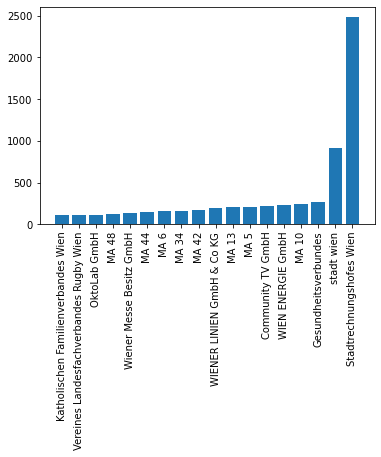

In [304]:
import matplotlib.pyplot as plt

plt.bar(*zip(*most_freq.items()))
plt.xticks(rotation=90)
plt.show()

In [218]:
node_size = {k: v for k, v in node_size.items() if v > 2}
node_size

{'Stadtrechnungshofausschusses': 95,
 'Stadtrechnungshofes Wien': 2483,
 'MA 46': 49,
 'stadt wien': 919,
 'MA 17': 83,
 'Europäische Union GmbH': 9,
 'EU': 23,
 'Verein PEREGRINA': 17,
 'MA 57': 111,
 'Privatkrankenanstalt Sanatorium Hera': 37,
 'Krankenfürsorgeanstalt der Bediensteten': 4,
 'KFA': 6,
 'Krankenfürsorgeanstalt': 4,
 'MA 58': 35,
 'MA 60': 25,
 'MA 27': 14,
 'MA 11': 100,
 'MA 51': 89,
 'Gesundheitsverbundes': 262,
 'MA 34': 164,
 'MA 49': 115,
 'MA 22': 112,
 'MA 10': 247,
 'MA 7': 61,
 'MA 5': 210,
 'Unternehmung Wiener Gesundheitsverbund': 66,
 'Digitalisierung und Internationales': 7,
 'Wirtschaftsagentur Wien': 7,
 'Wohnbau': 8,
 'Arbeit': 9,
 'Geschäftsgruppe Kultur und Wissenschaft': 9,
 'Gesundheit und Sport': 17,
 'Geschäftsgruppe Soziales': 17,
 'Wirtschaft': 16,
 'MA 62': 26,
 'MA 69': 43,
 'Geschäftsgruppe Finanzen': 23,
 'Stadterneuerung und Frauen': 8,
 'Stadtrechnungshofbericht': 3,
 'Internationales und Wiener Stadtwerke': 9,
 'MA 13': 205,
 'MA 29': 15,

In [229]:
# edge size calculation from all_results_pairs:

edge_size = {}


for i in all_results_pairs:
    for j in all_results_pairs[i]:

        if (j[0],j[1]) not in edge_size:
            edge_size.update({(j[0],j[1]):j[2]})
        else:
            edge_size[(j[0],j[1])] = edge_size[(j[0],j[1])] + j[2]

edge_size

{('Stadtrechnungshofausschusses', 'Stadtrechnungshofes Wien'): 95,
 ('MA 46', 'Stadtrechnungshofausschusses'): 7,
 ('MA 46', 'Stadtrechnungshofes Wien'): 49,
 ('Stadtrechnungshofausschusses', 'stadt wien'): 69,
 ('MA 17', 'stadt wien'): 25,
 ('Stadtrechnungshofes Wien', 'stadt wien'): 672,
 ('Europäische Union GmbH', 'stadt wien'): 9,
 ('EU', 'stadt wien'): 22,
 ('Verein PEREGRINA', 'stadt wien'): 3,
 ('MA 57', 'stadt wien'): 21,
 ('MA 17', 'Stadtrechnungshofausschusses'): 14,
 ('Europäische Union GmbH', 'Stadtrechnungshofausschusses'): 3,
 ('EU', 'Stadtrechnungshofausschusses'): 5,
 ('Stadtrechnungshofausschusses', 'Verein PEREGRINA'): 2,
 ('MA 57', 'Stadtrechnungshofausschusses'): 13,
 ('MA 17', 'Stadtrechnungshofes Wien'): 68,
 ('Europäische Union GmbH', 'MA 17'): 4,
 ('EU', 'MA 17'): 3,
 ('MA 17', 'Verein PEREGRINA'): 3,
 ('MA 17', 'MA 57'): 18,
 ('Europäische Union GmbH', 'Stadtrechnungshofes Wien'): 9,
 ('EU', 'Stadtrechnungshofes Wien'): 20,
 ('Stadtrechnungshofes Wien', 'Verein

In [230]:
edge_size = {k: v for k, v in edge_size.items() if v > 2}
edge_size

{('Stadtrechnungshofausschusses', 'Stadtrechnungshofes Wien'): 95,
 ('MA 46', 'Stadtrechnungshofausschusses'): 7,
 ('MA 46', 'Stadtrechnungshofes Wien'): 49,
 ('Stadtrechnungshofausschusses', 'stadt wien'): 69,
 ('MA 17', 'stadt wien'): 25,
 ('Stadtrechnungshofes Wien', 'stadt wien'): 672,
 ('Europäische Union GmbH', 'stadt wien'): 9,
 ('EU', 'stadt wien'): 22,
 ('Verein PEREGRINA', 'stadt wien'): 3,
 ('MA 57', 'stadt wien'): 21,
 ('MA 17', 'Stadtrechnungshofausschusses'): 14,
 ('Europäische Union GmbH', 'Stadtrechnungshofausschusses'): 3,
 ('EU', 'Stadtrechnungshofausschusses'): 5,
 ('MA 57', 'Stadtrechnungshofausschusses'): 13,
 ('MA 17', 'Stadtrechnungshofes Wien'): 68,
 ('Europäische Union GmbH', 'MA 17'): 4,
 ('EU', 'MA 17'): 3,
 ('MA 17', 'Verein PEREGRINA'): 3,
 ('MA 17', 'MA 57'): 18,
 ('Europäische Union GmbH', 'Stadtrechnungshofes Wien'): 9,
 ('EU', 'Stadtrechnungshofes Wien'): 20,
 ('Stadtrechnungshofes Wien', 'Verein PEREGRINA'): 15,
 ('MA 57', 'Stadtrechnungshofes Wien'): 

In [231]:
import networkx as nx
import matplotlib.pyplot as plt

In [234]:
G = nx.Graph()
for i in edge_size:
    G.add_edge(i[0], i[1], weight = edge_size[i])

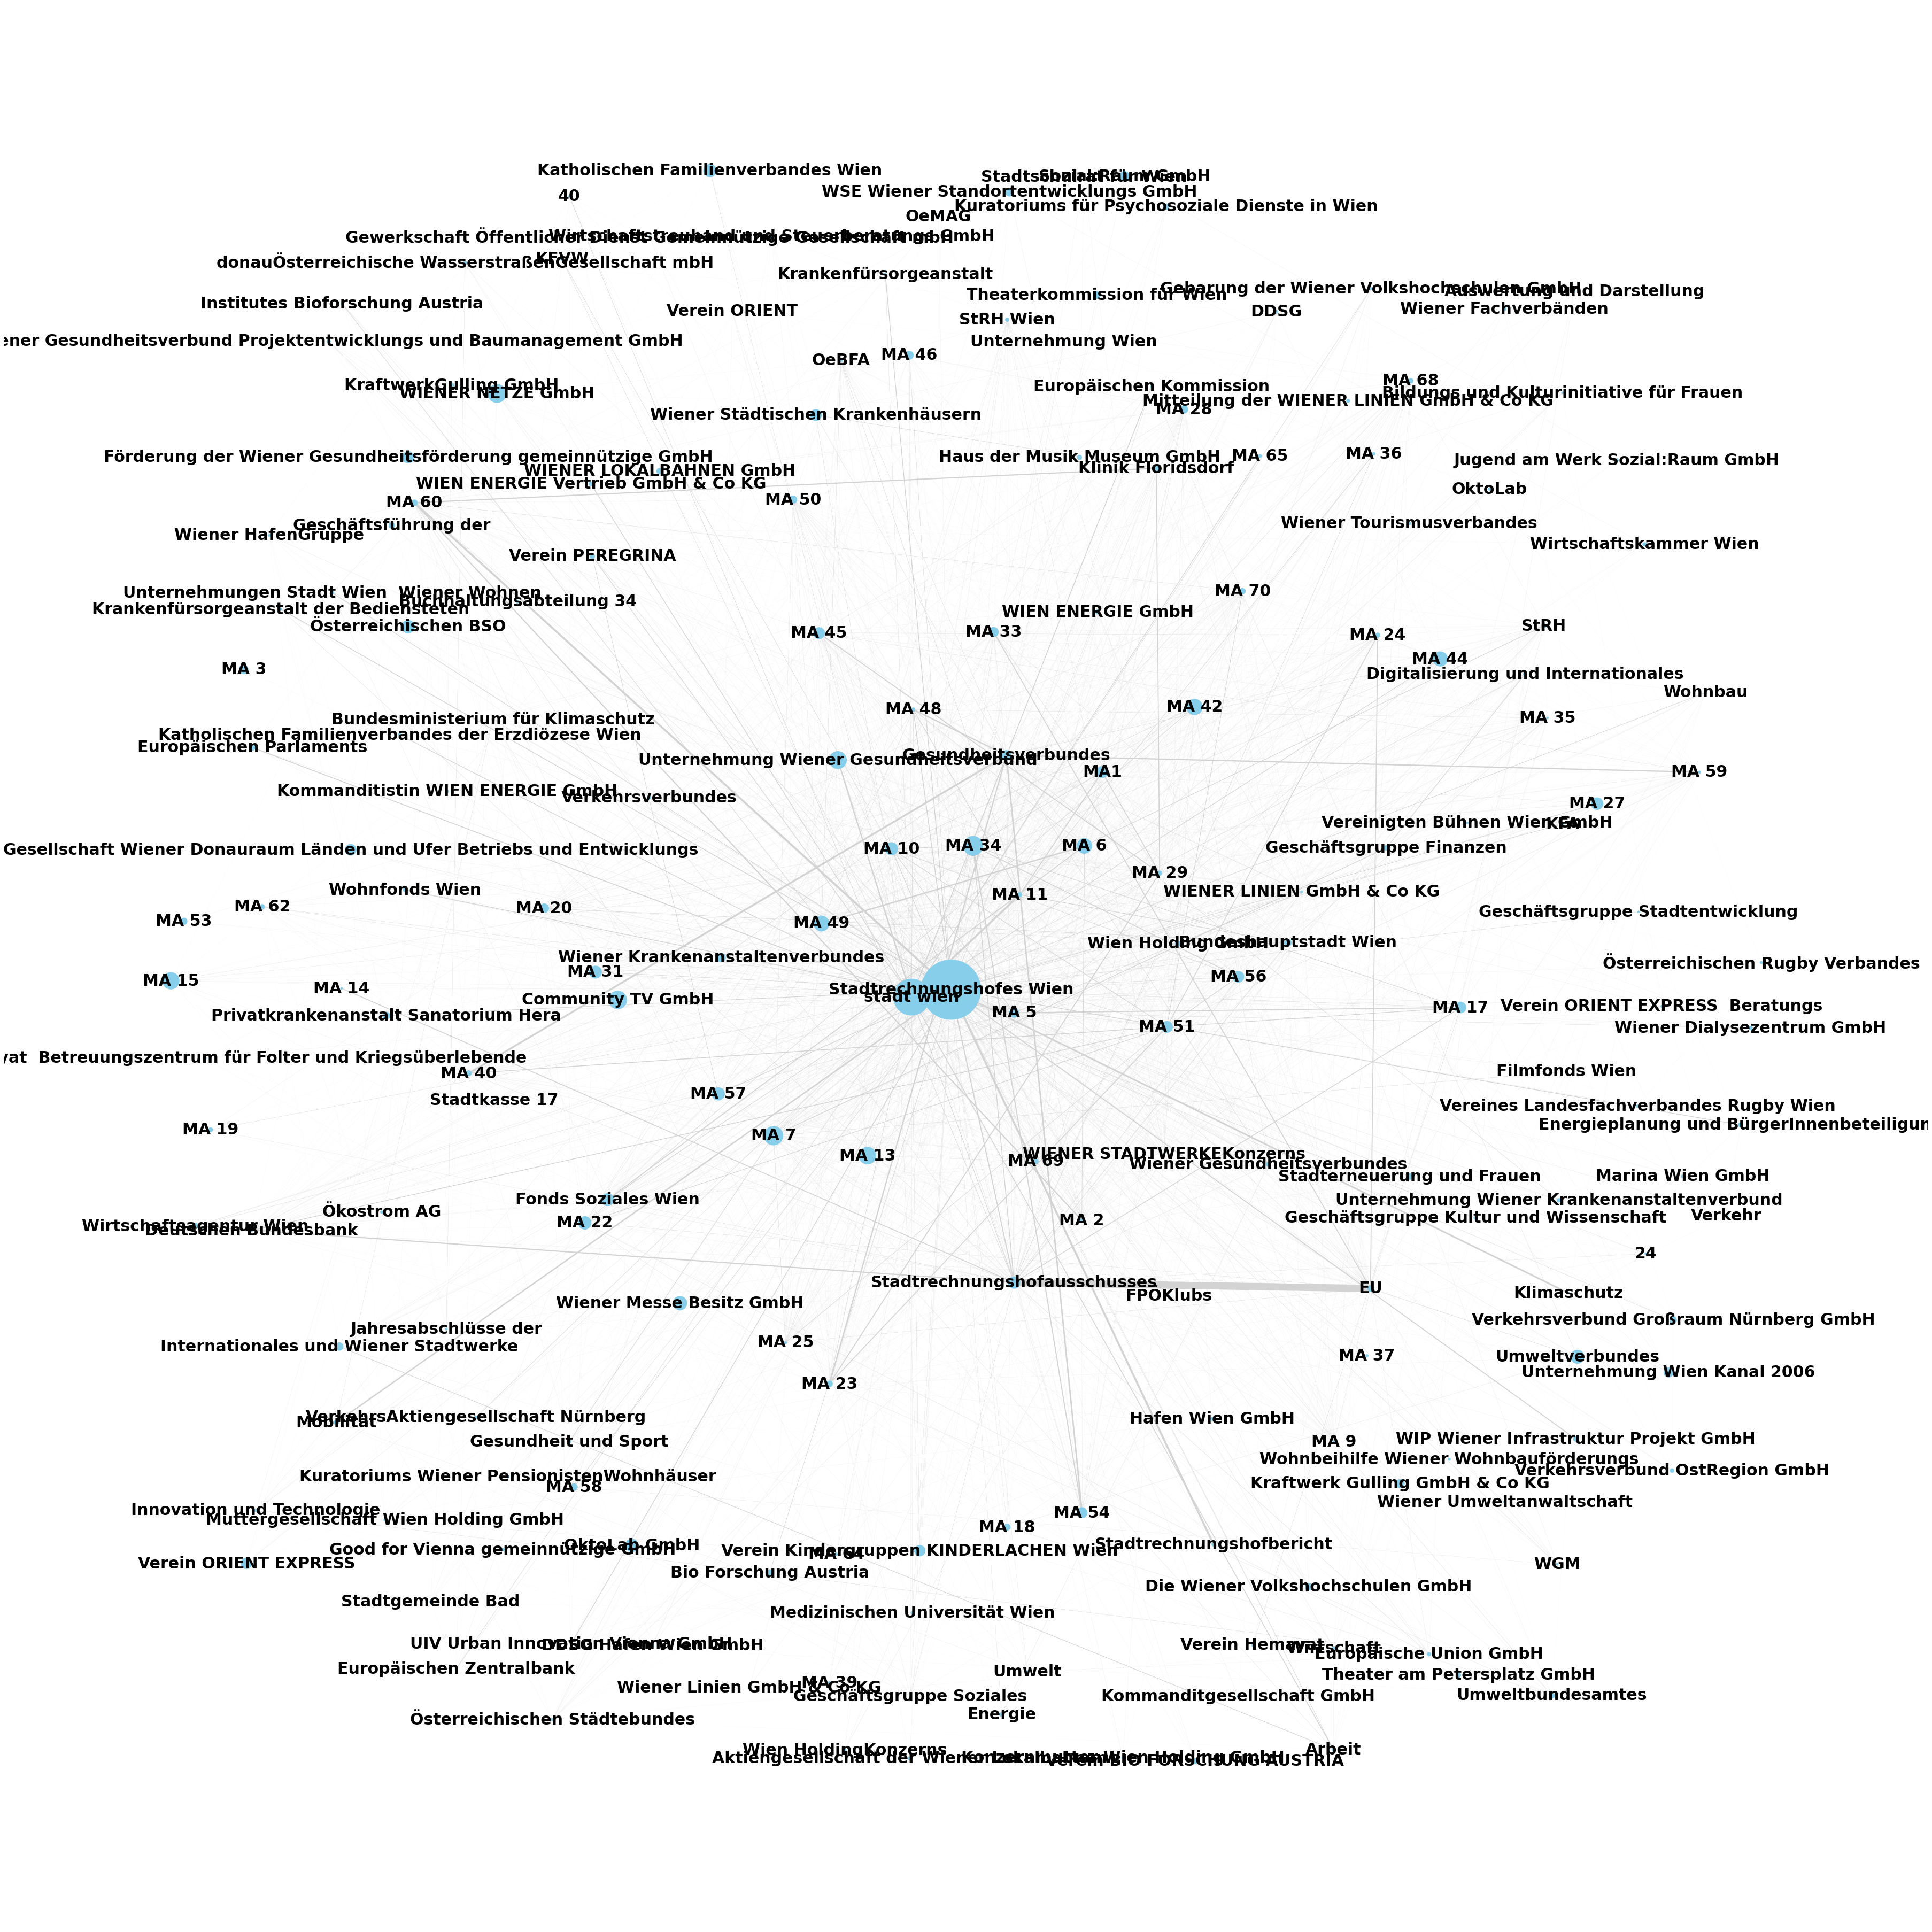

In [271]:
weights = []
for i in edge_size:
    weights.append(edge_size[i]/50)
    
#set positions of nodes
pos = nx.spring_layout(G, k=1.2, iterations=10)

plt.figure(figsize = (50,50))
#draw graph
nx.draw(G, pos, with_labels=True, font_size = 30, font_weight = 'bold',
        node_size=[v*5 for v in node_size.values()], node_color="skyblue",edge_color='lightgrey',width=weights)  
plt.savefig('test.jpg', bbox_inches='tight')
plt.show() 

In [285]:
G = nx.Graph()
weights=[]

for i in edge_size:
    if edge_size[i]> 50:
        G.add_edge(i[0], i[1], weight = edge_size[i])
        weights.append(edge_size[i]/30)

In [280]:
new_node_size = {}
for i in node_size:
    if i in list(G.nodes()):
        new_node_size.update({i:node_size[i]})

In [289]:
new_node_size

{'Stadtrechnungshofausschusses': 95,
 'Stadtrechnungshofes Wien': 2483,
 'stadt wien': 919,
 'MA 17': 83,
 'MA 57': 111,
 'MA 11': 100,
 'MA 51': 89,
 'Gesundheitsverbundes': 262,
 'MA 34': 164,
 'MA 49': 115,
 'MA 22': 112,
 'MA 10': 247,
 'MA 5': 210,
 'Unternehmung Wiener Gesundheitsverbund': 66,
 'MA 13': 205,
 'MA 6': 158,
 'Wiener Krankenanstaltenverbundes': 55,
 'MA 20': 57,
 'MA1': 89,
 'MA 56': 89,
 'Wien Holding GmbH': 90,
 'WIENER STADTWERKEKonzerns': 107,
 'MA 48': 127,
 'WIEN ENERGIE GmbH': 236,
 'Fonds Soziales Wien': 107,
 'MA 54': 77,
 'Katholischen Familienverbandes Wien': 115,
 'MA 2': 56,
 'Verein Hemayat': 93,
 'Sozial:Raum GmbH': 72,
 'Verein Kindergruppen KINDERLACHEN Wien': 81,
 'Wiener Messe Besitz GmbH': 133,
 'WIENER LINIEN GmbH & Co KG': 195,
 'MA 42': 175,
 'Kraftwerk Gulling GmbH & Co KG': 52,
 'MA 33': 65,
 'Vereines Landesfachverbandes Rugby Wien': 115,
 'Community TV GmbH': 225,
 'OktoLab GmbH': 117,
 'Verein ORIENT EXPRESS': 81,
 'Wiener Städtischen Kra

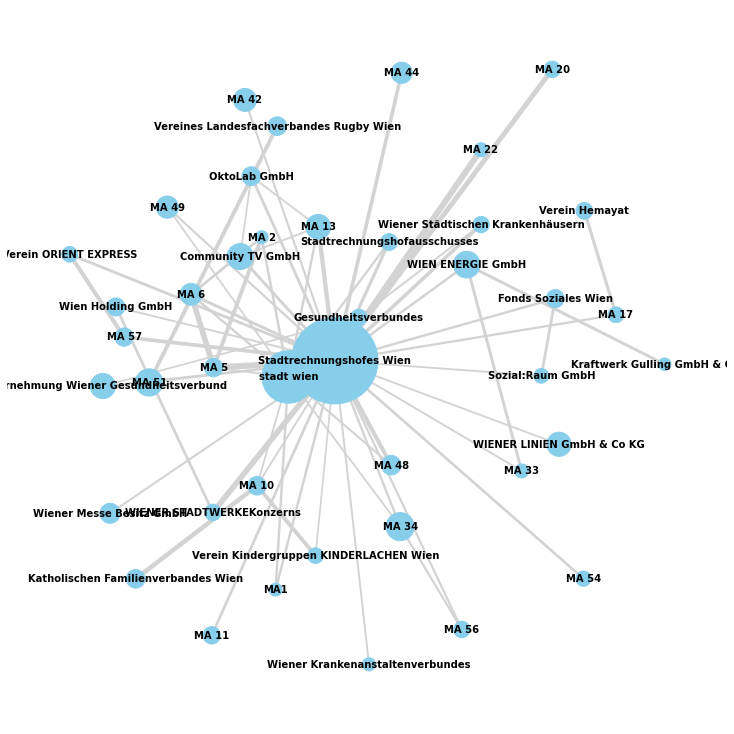

In [296]:
pos = nx.spring_layout(G, k=1.2, iterations=10)

plt.figure(figsize = (10,10))
#draw graph
nx.draw(G, pos, with_labels=True, font_size = 10, font_weight = 'bold',
        node_size = [v*3 for v in new_node_size.values()], node_color="skyblue",edge_color='lightgrey',width=weights)  
plt.savefig('test_small.jpg', bbox_inches='tight')
plt.show() 